# Laboratoire numéro 1

Imports

In [199]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

## Step 1

In [243]:
nodes = pd.read_csv('Documentation/nodes.csv', header=None, names=["Node","x_position","y_position"], index_col=0)
edges = pd.read_csv('Documentation/links.csv', header=None, names=[
    "Link ID", 
    "Length (m)",
    "Number of lanes", 
    "Starting node ID",
    "Ending node ID", 
    "Region"], index_col=0)
occupancy = pd.read_csv('Documentation/occupancy.csv', index_col = 0)
flow = pd.read_csv('Documentation/flow.csv', index_col = 0)

time_in_min = 60
time = time_in_min * 60
occupancy_at_t = occupancy.loc[time]
occupancy_at_t.name = f"Occupancy at time {time}"
color_at_t = occupancy_at_t/100
color_at_t.name = f"Colors in gray scale at time {time}"
color_at_t = color_at_t.astype(str)

edges_at_t = edges
edges_at_t["Occupancy"] = occupancy_at_t.values
edges_at_t["Color"] = color_at_t
edges_at_t = edges_at_t.replace(np.nan,1)

TypeError: Invalid shape (870,) for image data

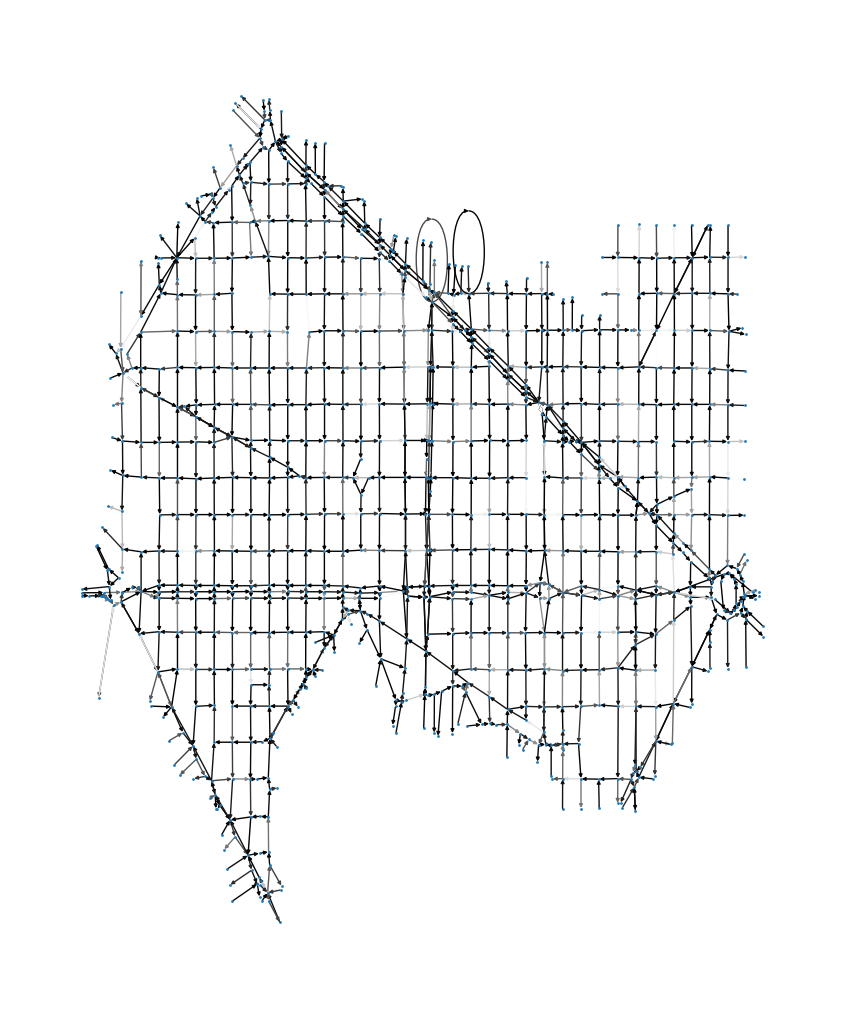

In [248]:
G = nx.from_pandas_edgelist(edges_at_t, create_using = nx.MultiDiGraph, source = "Starting node ID", target= "Ending node ID", edge_attr=["Length (m)", "Number of lanes", "Region","Occupancy","Color"])

plt.figure(figsize=(12,10))
nx.draw(G, arrowsize = 5, node_size = 1, pos=nodes.transpose(), edge_cmap = mpl.colormaps['Greys'], edge_color = color_at_t)
plt.colorbar()
plt.show()

## Step 2

(80, 1570)
(80,)


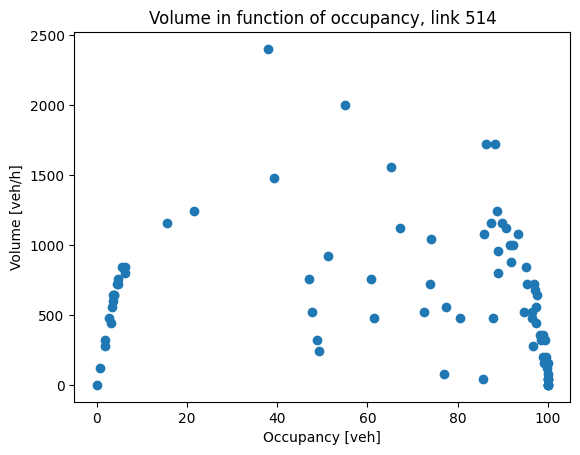

In [213]:
def vol_occ_graph_1link(number_link):

    flow_l = flow.loc[:, f'{number_link}']*3600/90 # In vehicles per hour
    occupancy_single_road = occupancy.loc[:, f'{number_link}'] # In vehicles

    print(flow.shape)
    print(occupancy_single_road.shape)

    plt.scatter(occupancy_single_road, flow_l)
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, link {number_link}")
    plt.show()

    return None

vol_occ_graph_1link(514)

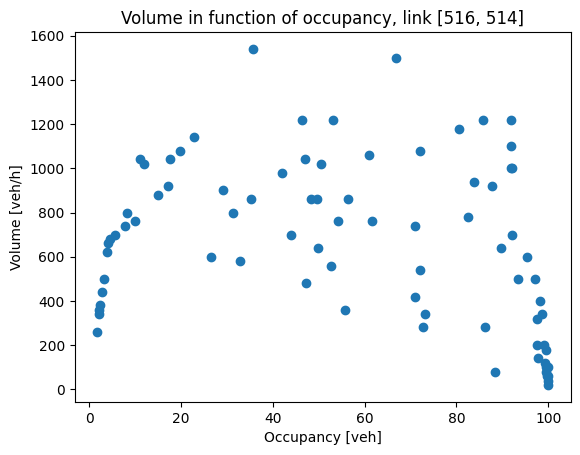

In [212]:
def vol_occ_graph_2links(number_link):

    flow_l= flow[[f'{number_link[0]}', f'{number_link[1]}']]
    flow_mean = flow_l.mean(axis=1)*3600/90

    occupancy_l = occupancy[[f'{number_link[0]}', f'{number_link[1]}']]
    occupancy_mean = occupancy_l.mean(axis=1)

    plt.scatter(occupancy_mean, flow_mean)   
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, link {number_link}") 
    plt.show()

    return None

number_link = [516, 514]

vol_occ_graph_2links(number_link)

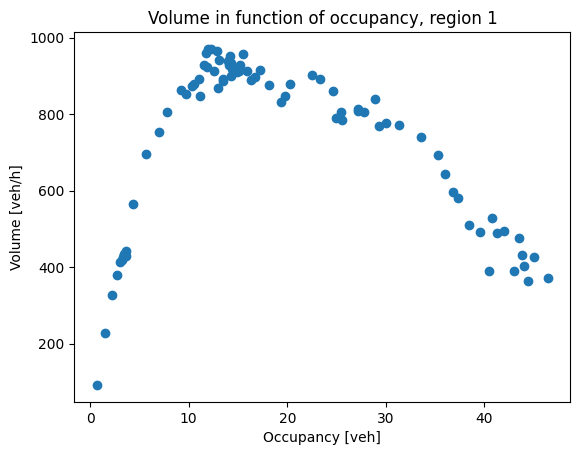

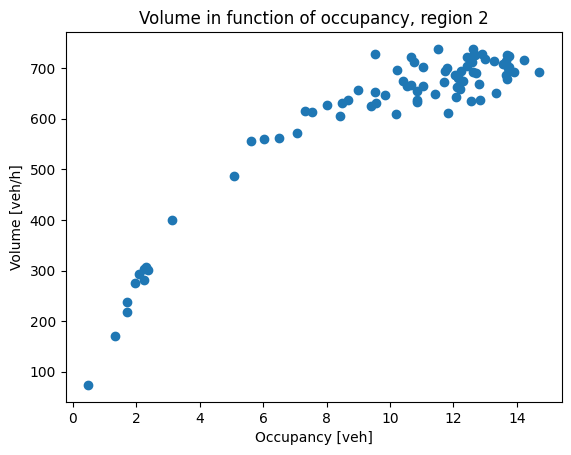

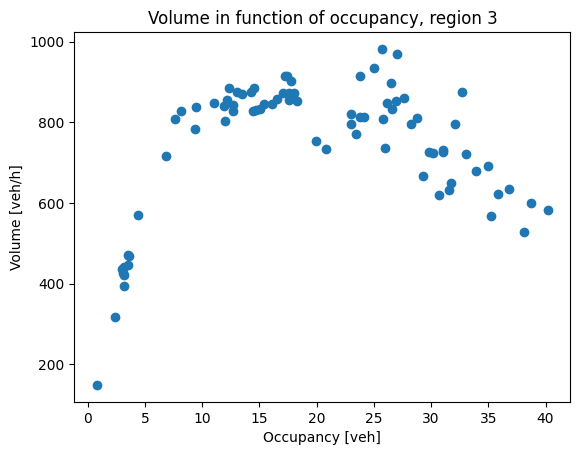

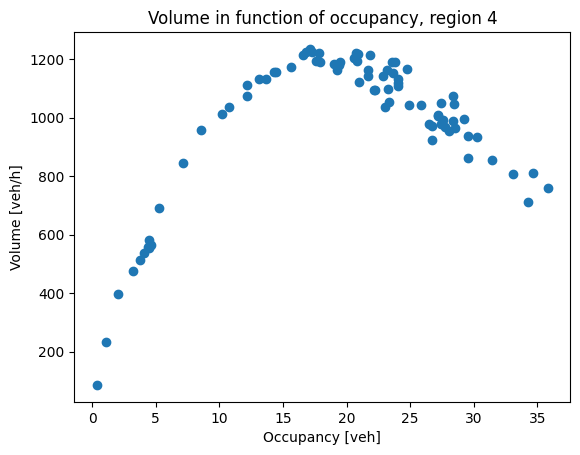

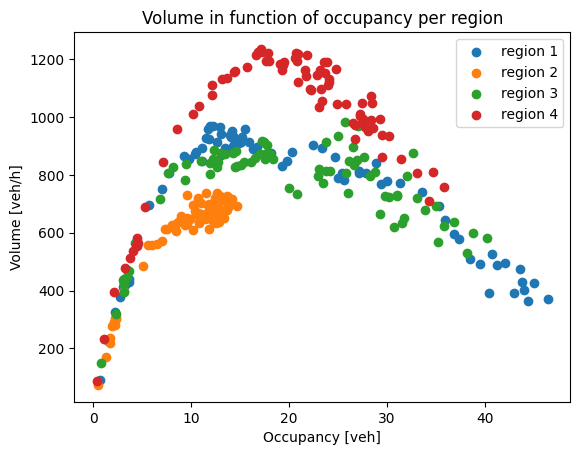

In [231]:
def vol_occ_graph_region(region):

    number_link = []

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link.append(str(index))
        
    flow_l= flow[number_link]
    flow_mean = flow_l.mean(axis=1)*3600/90

    occupancy_l = occupancy[number_link]
    occupancy_mean = occupancy_l.mean(axis=1)

    plt.scatter(occupancy_mean, flow_mean)   
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, region {region}")  
    plt.show()

    return occupancy_mean, flow_mean

# region = [1,2,3,4]

# for i in region:
#     occ_mean_i, flow_mean_i = vol_occ_graph_region(i)
#     plt.scatter(occ_mean_i, flow_mean_i, label=f'Region {region}')  

# plt.legend()
# plt.show()

occ1, flow1 = vol_occ_graph_region(1)
occ2, flow2 = vol_occ_graph_region(2)
occ3, flow3 = vol_occ_graph_region(3)
occ4, flow4 = vol_occ_graph_region(4)

plt.scatter(occ1, flow1, label=f'region 1') 
plt.scatter(occ2, flow2, label=f'region 2') 
plt.scatter(occ3, flow3, label=f'region 3') 
plt.scatter(occ4, flow4, label=f'region 4')   
plt.xlabel("Occupancy [veh]")
plt.ylabel("Volume [veh/h]")
plt.title(f"Volume in function of occupancy per region")  
plt.legend()
plt.show()

# Step 3

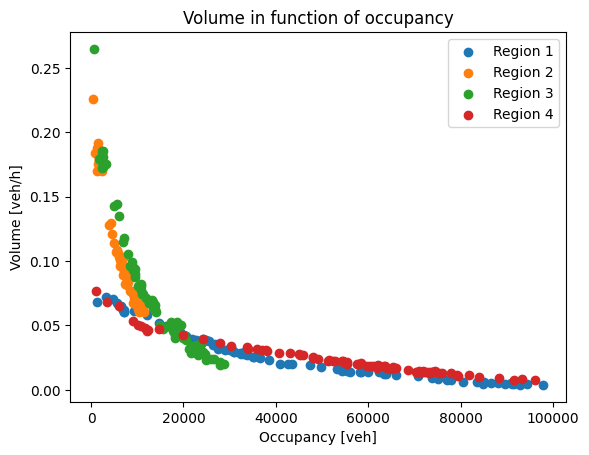

In [241]:
 
regions = [1,2,3,4]

for region in regions:

    number_link_int = []
    number_link_str = []

    L = 5/1000 # Average vehicle lenght [m]
    Ld = 2/1000 # Detector lenght [m]

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link_int.append(int(index))
            number_link_str.append(str(index))

    number_lane = edges.loc[number_link_int, "Number of lanes"].to_numpy()
    length_lane = edges.loc[number_link_int, "Length (m)"].to_numpy()

    occupancy_region = occupancy[number_link_str].to_numpy()

    number_lane = np.tile(number_lane, (number_lane.shape[0], 1))

    density = (occupancy_region / 100) @ number_lane.T / (Ld + L)

    flow_region = flow[number_link_str].to_numpy() * 3600 / 90

    link_speed = flow_region @ density.T

    length_lane = np.tile(length_lane, (length_lane.shape[0], 1))

    mean_speed = np.mean(flow_region @ length_lane, axis=1) / np.mean(density @ length_lane, axis=1)

    average_density = np.mean(density, axis=1)

    plt.scatter(average_density, mean_speed, label=f'Region {region}')  


plt.xlabel("Occupancy [veh]")
plt.ylabel("Volume [veh/h]")
plt.title(f"Volume in function of occupancy")  
plt.legend()   
plt.show()

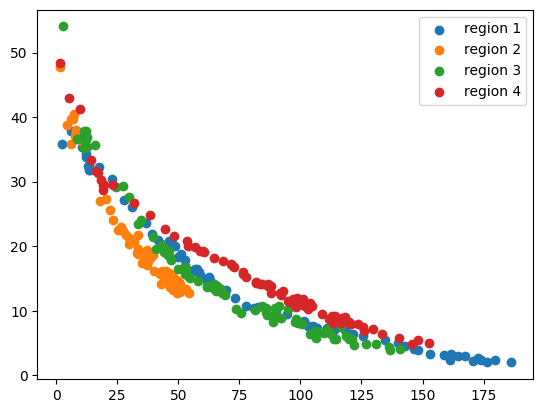

In [242]:
#Version de JC

Region = [1,2,3,4]

for region in Region:


    number_link_int = []
    number_link_str = []

    L = 5/1000
    Ld = 2/1000

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link_int.append(int(index))
            number_link_str.append(str(index))

    number_lane = edges.loc[number_link_int, "Number of lanes"].to_numpy()
    length_lane = edges.loc[number_link_int, "Length (m)"].to_numpy()
    #print(length_lane.shape)

    occupancy_region = occupancy[number_link_str].to_numpy() #%

    #number_lane = np.tile(number_lane, (number_lane.shape[0], 1))
    
    number_lane = np.diag(number_lane)
    #print('occupancy_region', occupancy_region, occupancy_region.shape)
    #print('np.transpose(number_lane)', np.transpose(number_lane), np.transpose(number_lane).shape)

    density = (occupancy_region/100)@np.transpose(number_lane)/(Ld + L)
    #print(1/number_lane


    flow_region = flow[number_link_str].to_numpy()*3600/90

    #print('flow',flow_region, flow_region.shape)
    #print('length_lane', length_lane, length_lane.shape)

    link_speed = flow_region@np.transpose(density)


    #print('flow', flow_region.shape)
    #print('density', np.max(density), density.shape)

    length_lane = np.tile(length_lane, (length_lane.shape[0], 1))
    #print('density', density, density.shape)
    #print(flow_region@length_lane)
    #print('density',density@length_lane)

    mean_speed = np.sum(flow_region@length_lane, axis=1)/np.sum(density@length_lane, axis=1)

    #print('mean_speed', mean_speed, mean_speed.shape)
    #print('density', np.max(density), density.shape)
    #print('length_lane', length_lane, length_lane.shape)
    average_density = np.mean(density,axis=1)

    plt.scatter(average_density, mean_speed, label=f'region {region}')   
   
plt.legend()    
plt.show()

# Old versions

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import csv

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

graph_type = nx.Graph()

nodes = pd.read_csv('Documentation/nodes.csv', header=None)
nodes.columns = ["Node ID", "x_coordinate", "y_coordinate"]
nodescoordinates = nodes.iloc[:,1:]
nodesid = nodes.iloc[:,0]

links = pd.read_csv('Documentation/links.csv', header=None)
links.columns = ["Link ID", "Lenght", "Number of lanes", "Starting node ID", "Ending node ID", "Region"]

couple = pd.Series

#G = nx.from_pandas_edgelist(nodesid, source='x_coordinate', target='y_coordinate', create_using=graph_type)

G = nx.Graph()

G.add_nodes_from(nodes["Node ID"])
# G.add_edges_from(links[])

axes = plt.axes()

nx.draw(G, ax = axes)

# printgraph()

# print("test")


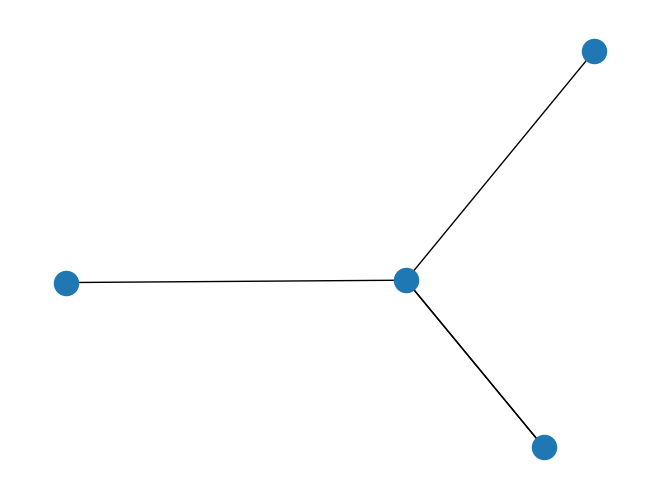

In [13]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2, 0],
        "target": [2, 2, 3, 2],
        "my_edge_key": ["A", "B", "C", "D"],
        "weight": [3, 4, 5, 6],
        "color": ["red", "blue", "blue", "blue"],
    }
)
G = nx.from_pandas_edgelist(
    edges,
    edge_key="my_edge_key",
    edge_attr=["weight", "color"],
    create_using=nx.MultiGraph(),
)
G[0][2]

nx.draw(G)
plt.show()